_Variational AutoEncoders_

1. Train a VAE model for generating new data similar to training set.
	1. Train the model on fashionMNIST dataset.
	1. Generate 30 new samples using the learned model and plot them.

	Dataset: fashionMNIST (https://github.com/zalandoresearch/fashion-mnist?tab=readme-ov-file#get-the-data)

Using device: cuda
Epoch [1/15], Loss: 306.5481
Epoch [2/15], Loss: 262.0312
Epoch [3/15], Loss: 255.4309
Epoch [4/15], Loss: 253.1077
Epoch [5/15], Loss: 251.6192
Epoch [6/15], Loss: 250.5073
Epoch [7/15], Loss: 249.7965
Epoch [8/15], Loss: 249.0529
Epoch [9/15], Loss: 248.4079
Epoch [10/15], Loss: 248.0230
Epoch [11/15], Loss: 247.6166
Epoch [12/15], Loss: 247.2910
Epoch [13/15], Loss: 247.1014
Epoch [14/15], Loss: 246.6454
Epoch [15/15], Loss: 246.5031


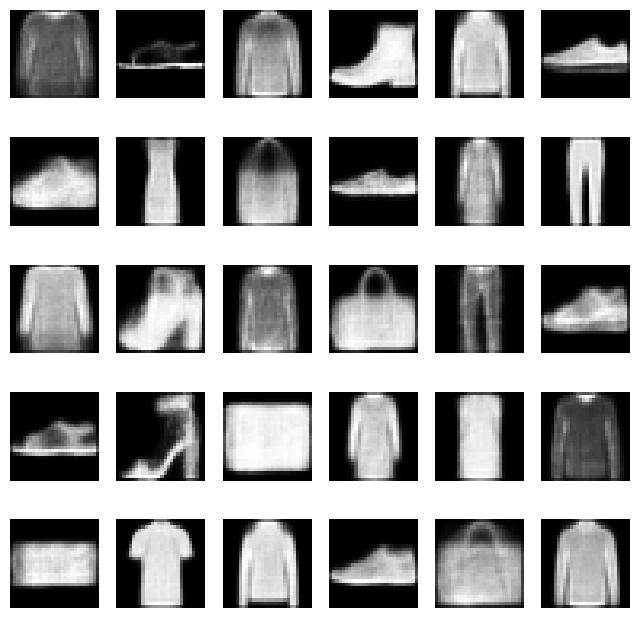

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = x[:, :self.latent_dim], x[:, self.latent_dim:]
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

latent_dim = 32
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    KL_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL_div

epochs = 15
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")

vae.eval()
with torch.no_grad():
    z = torch.randn(30, latent_dim).to(device)
    generated_images = vae.decoder(z).view(-1, 28, 28)

    fig, axes = plt.subplots(5, 6, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].cpu(), cmap="gray")
        ax.axis("off")
    plt.show()
